In [2]:
import torch
import cv2
import os
import glob
from torch.utils.data import Dataset
import random
import numpy as np

from torchvision import transforms
from PIL import Image


class Gopro_Loader(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        # 讀取所有影像的檔名
        self.imgs = glob.glob(os.path.join(data_path, 'blur/*.png'))

    def __getitem__(self, idx):
        # 讀取影像
        img_path = self.imgs[idx]
        label_path = img_path.replace("blur", "sharp")
        
        # 讀取標籤
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
        

        return img, label

    def __len__(self):
        return len(self.imgs)

In [3]:
img = cv2.imread('dataset_gopro/test/sharp/GOPR0871_11_01_000184.png')
print (img.shape)

(720, 1280, 3)


In [37]:
from torch import nn
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)
#         self.upconv1 = self.OutConv(32*2, out_channels)

    def __call__(self, x):

        # downsampling part
        print("x shape:", x.shape)
        conv1 = self.conv1(x)
        print("conv1 shape:", conv1.shape)
        conv2 = self.conv2(conv1)
        print("conv2 shape:", conv2.shape)
        conv3 = self.conv3(conv2)
        print("conv3 shape:", conv3.shape)

        upconv3 = self.upconv3(conv3)
        print("upconv3 shape:", upconv3.shape)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        print("upconv2 shape:", upconv2.shape)
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        print("upconv1 shape:", upconv1.shape)

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand
    

In [34]:
from torch import nn
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)
#         self.upconv1 = self.OutConv(32*2, out_channels, 3)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand
    
        

In [38]:
model = UNet()
# 创建一个大小为 [1, 3, 256, 256] 的张量
input_tensor = torch.rand(1, 3, 256, 256)

# 将张量传递给模型进行前向传播
output_tensor = model(input_tensor)

x shape: torch.Size([1, 3, 256, 256])
conv1 shape: torch.Size([1, 32, 128, 128])
conv2 shape: torch.Size([1, 64, 64, 64])
conv3 shape: torch.Size([1, 128, 32, 32])
upconv3 shape: torch.Size([1, 64, 64, 64])
upconv2 shape: torch.Size([1, 32, 128, 128])
upconv1 shape: torch.Size([1, 3, 256, 256])


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

def train_net(net, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device='cpu'):
    # 将模型移动到指定设备
    net.to(device)
    
    # 定义损失函数和优化器
    # reuse the gaussian kernel with SSIM & MS_SSIM. 
    criterion = SSIM(data_range=255, size_average=True, channel=3) # channel=1 for grayscale images
#     criterion = ssim_module()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    best_loss = float('inf')
    
    # 训练模型
    for epoch in range(num_epochs):
        net.train() # 将模型设为训练模式
        train_loss = 0.0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # 将梯度清零
            optimizer.zero_grad()
            
            # 前向传播，计算预测结果和损失
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # 保存loss值最小的网络参数
            if loss < best_loss:
                best_loss = loss
                torch.save(net.state_dict(), 'best_model.pth')
            
            # 反向传播，更新参数
            loss.backward()
            optimizer.step()
            
            # 统计损失
            train_loss += loss.item()
        
        # 在验证集上测试模型，并记录损失
        net.eval() # 将模型设为测试模式
        val_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                
                # 前向传播，计算预测结果和损失
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                
                # 统计损失
                val_loss += loss.item()
                
        # 打印每个epoch的损失
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8
net = UNet()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
# 指定训练集地址，开始训练
train_data_path = "dataset_gopro/train"
gopro_dataset = Gopro_Loader(data_path=train_data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
                                        dataset=gopro_dataset,
                                        batch_size=batch_size, 
                                        shuffle=True)

test_data_path = "dataset_gopro/eval"
gopro_test_dataset = Gopro_Loader(data_path=test_data_path, transform=transform)
val_loader = torch.utils.data.DataLoader(
                                        dataset=gopro_test_dataset,
                                        batch_size=batch_size, 
                                        shuffle=True)

train_net(net, train_loader, val_loader, num_epochs=100, learning_rate=0.0001, device=device)

ValueError: Input images should have the same dimensions.

In [30]:

from torch.utils.data import DataLoader

# 选择设备，有cuda用cuda，没有就用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载网络，图片三通道，分类为1。
net = UNet()
# 将网络拷贝到device中
net.to(device=device)
# 加载模型参数
net.load_state_dict(torch.load('best_model.pth', map_location=device))
# 测试模式
net.eval()

tests_path = glob.glob('dataset_gopro/test/blur/*.png')
print (tests_path)

# 遍历所有图片
for test_path in tests_path:
    # 保存结果地址
    save_res_path = test_path.split('.')[0] + '_res.png'
    # 读取图片
    img = cv2.imread(test_path)
    print (img.shape)
    # 转为batch为1，通道为1，大小为512*512的数组
    img = img.reshape(1, 3, img.shape[0], img.shape[1])
    print (img.shape)
    # 转为tensor
    img_tensor = torch.from_numpy(img)
    
    # 将数据拷贝到device中
    image = img_tensor.to(device=device, dtype=torch.float32)
    # 使用网络参数，输出预测结果
    pred = net(image)
    print (pred.shape)
    
    pred = pred.detach().cpu().numpy()

    print (pred.shape)
    # 保存图片
    save_res_path = test_path.split('.')[0] + '_res.png'
    cv2.imwrite(save_res_path, pred[0].transpose(1, 2, 0).astype('uint8'))

#     cv2.imwrite(save_res_path, pred)


['dataset_gopro/test/blur\\GOPR0871_11_01_000181.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000182.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000183.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000184.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000185.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000186.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000187.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000188.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000189.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000190.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000191.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000192.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000193.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000194.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000195.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000196.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000197.png', 'dataset_gopro/test/blur\\GOPR0871_11_01_000198.png', 'dataset_gopro/test/blur\\G

(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1280)
torch.Size([1, 3, 720, 1280])
(1, 3, 720, 1280)
(720, 1280, 3)
(1, 3, 720, 1

KeyboardInterrupt: 

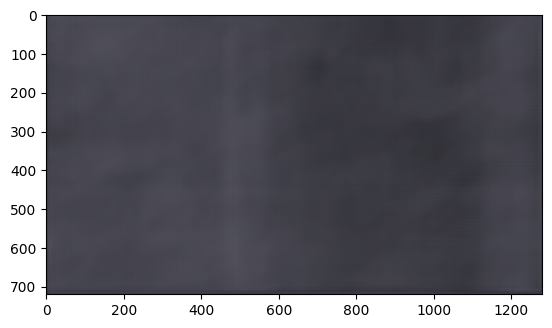

In [12]:
import matplotlib.pyplot as plt
plt.imshow(pred[0].transpose(1, 2, 0).astype('uint8'))
plt.show()

In [22]:
!pip install pytorch-msssim

Defaulting to user installation because normal site-packages is not writeable


In [23]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM